In [266]:
import pandas as pd 
import geopandas as gp
import altair as alt 
import gpdvega 
import json
import matplotlib.pyplot as plt
alt.renderers.enable('notebook') # render for Jupyter Notebook

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 500)

DATA_DIR = '/nas/dft/ire/stuartlynn/MTA_ACCESSIBILITY/MTAAlertScraper-master/data/'

In [267]:
# Not pulling from stuart nas drive until updated.
ee_master = pd.read_csv("EE_master_list.csv")

stations = gp.read_file(DATA_DIR+'Subway Stations.geojson')
lines = gp.read_file(DATA_DIR+'Subway Lines.geojson')
isochrones=gp.read_file(DATA_DIR+'isochrones.geojson')
outages = pd.read_csv(DATA_DIR + "outages.csv.gz")
turnstile = pd.read_csv(DATA_DIR + "subway_turnstile_join.csv")

In [268]:
column_mappings = {}
with open("/nas/dft/ire/pcao/mta_hack/column_mappings") as input_file:
    for line in input_file:        
        (key,val) = line.split(",")
        column_mappings[key+"E"] = val.strip()

# Load census data
gp_df = gp.read_file(DATA_DIR + "Population_stats.geojson")
gp_df.columns = gp_df.columns.str.replace("_","")
gp_df = gp_df.rename(columns=column_mappings)

# Drop all the B01001 columns
gp_df = gp_df.iloc[:, ~gp_df.columns.str.contains('B01001', case=False)]

In [269]:
pop = gp_df[['state', 'county', 'tract', 'Total', 'geometry']].copy()

pop['disabled'] = gp_df['No Ambulatory Difficulty'].sum(axis=1)
pop['not_disabled'] = gp_df['With An Ambulatory Difficulty'].sum(axis=1)
pop['pc_disabled'] = pop['disabled']*100/pop['Total']

In [270]:
ee_stations = set(ee_master.st_name_opd_format)
isochrones = isochrones[isochrones.station_id.isin(ee_stations)]
isochrones['fillColor'] = '#FFFFFF'
isochrones['fillOpacity'] = 1

In [271]:
better_tracts = gp.read_file("2010 Census Tracts.geojson")
pop_new = pd.merge(pop, better_tracts[['ct2010','geometry']], left_on='tract', right_on='ct2010')
pop_new['geometry'] = pop_new['geometry_x']
#pop_new.crs = better_tracts.crs

In [272]:
isochrones.head()

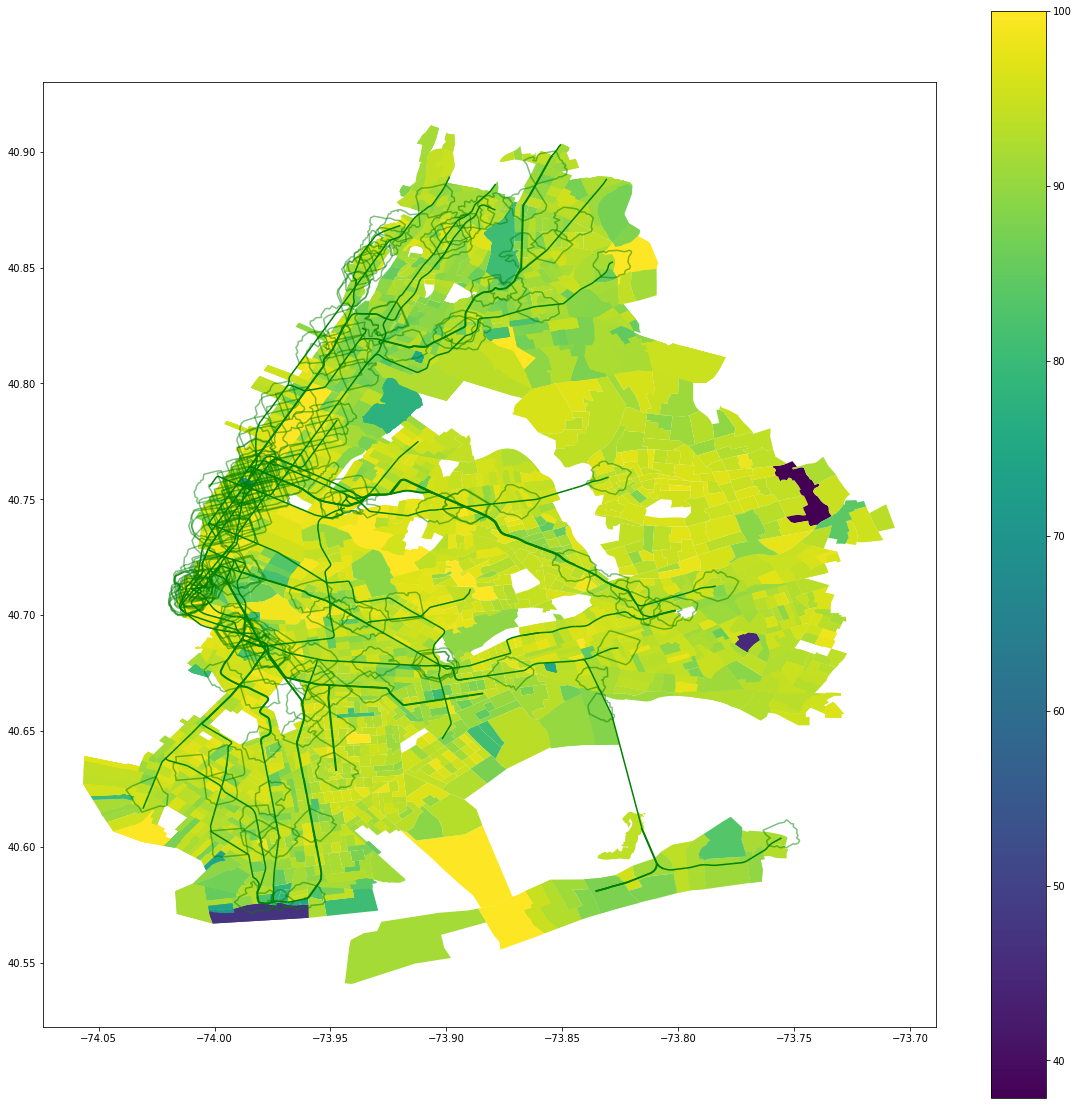

In [273]:
fig,ax = plt.subplots(figsize=(20,20))

pop_new[~ (pop_new.county=='085')].dropna().to_crs(epsg=4326).plot(column='pc_disabled',legend=True, ax=ax)
lines.plot(ax=ax, color='green')
isochrones.plot(ax=ax, color='green', alpha=0.5)


In [274]:
no_ambul = gp_df.sum()['No Ambulatory Difficulty'].sum()
no_ambul

6987449.0

In [275]:
ambul = gp_df.sum()['With An Ambulatory Difficulty'].sum()


In [276]:
gp_df.sum()['Total']

7512610.0

In [277]:
ambul + no_ambul

7512610.0